# Surgery

Purpose: Move all the weight and biases from MikeNet to TensorFlow

In [1]:
import os
os.chdir('/triangle_model')

In [2]:
import troubleshooting, meta, modeling, data_wrangling
import numpy as np
import tensorflow as tf
import pandas as pd
import altair as alt

from ipywidgets import interact

2021-11-12 19:16:05.260886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-12 19:16:05.268886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-12 19:16:05.269375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-12 19:16:05.270612: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

# Load model from disk

In [3]:
mn_weight = troubleshooting.MikeNetWeight("mikenet/Reading_Weight_v10") 

Weight Keys: ['Phono -> psh', 'Con -> csh', 'psh -> Semantics', 'csh -> Semantics', 'Semantics -> SemCleanup', 'SemCleanup -> Semantics', 'Bias -> Semantics', 'Bias -> SemCleanup', 'Bias -> psh', 'Bias -> csh', 'Semantics -> sph', 'sph -> Phono', 'Phono -> PhoCleanup', 'PhoCleanup -> Phono', 'Bias -> Phono', 'Bias -> sph', 'Bias -> PhoCleanup', 'Ortho -> oph', 'Ortho -> osh', 'oph -> Phono', 'osh -> Semantics', 'Bias -> oph', 'Bias -> osh']

Non-weight Keys: ['SimulatorSeed 114806242', 'TAOS Phono', 'DELAYS Phono', 'TAOS psh', 'DELAYS psh', 'TAOS sph', 'DELAYS sph', 'TAOS Semantics', 'DELAYS Semantics', 'TAOS SemCleanup', 'DELAYS SemCleanup', 'TAOS PhoCleanup', 'DELAYS PhoCleanup', 'TAOS Bias', 'DELAYS Bias', 'TAOS Ortho', 'DELAYS Ortho', 'TAOS oph', 'DELAYS oph', 'TAOS osh', 'DELAYS osh', 'TAOS Con', 'DELAYS Con', 'TAOS csh', 'DELAYS csh']


In [4]:
code_name = "surgery_v10"
batch_name = None
tf_root = "/triangle_model"

# Model configs
ort_units = 364
pho_units = 200
sem_units = 2446
hidden_os_units = 500
hidden_op_units = 500
hidden_ps_units = 300
hidden_sp_units = 300
pho_cleanup_units = 50
sem_cleanup_units = 50
pho_noise_level = 0.
sem_noise_level = 0.
activation = "sigmoid"

tau = 1 / 3
max_unit_time = 4.0
output_ticks = 13
inject_error_ticks = 11

# Training configs
learning_rate = 0.005
zero_error_radius = 0.1
save_freq = 20

# Environment configs
tasks = ("pho_sem", "sem_pho", "pho_pho", "sem_sem", "ort_pho", "ort_sem", "triangle")
wf_compression = "log"
wf_clip_low = 0
wf_clip_high = 999_999_999
oral_start_pct = 1.0
oral_end_pct = 1.0

oral_sample = 1_800_000
# oral_tasks_ps = (0.4, 0.4, 0.1, 0.1, 0.)
oral_tasks_ps = (0.4, 0.4, 0.05, 0.15, 0., 0., 0.)
transition_sample = 800_000
reading_sample = 15_000_000
# reading_tasks_ps = (0.2, 0.2, 0.05, 0.05, 0.5)
reading_tasks_ps = (0.2, 0.2, 0.05, 0.05, .1, .1, .3)

batch_size = 100
rng_seed = 2021

cfg = meta.ModelConfig.from_global(globals_dict=globals())
model = modeling.MyModel(cfg)
model.build()

UUID not found, regenerating.
Saved config json to /triangle_model/models/surgery_v10/model_config.json


In [5]:
for weight in model.weights:
    try:
        name = weight.name[:-2]
        weight.assign(mn_weight.weights_tf[name])
        print(f"Grafted mikenet weight {name} to tf.weights")

        # Post-load weight sanity check
        tf.debugging.assert_equal(mn_weight.weights_tf[name], weight)

    except KeyError:
        print(f"Missing weight {name} in mikenet")
        pass


Grafted mikenet weight w_hsp_sh to tf.weights
Grafted mikenet weight w_hsp_hp to tf.weights
Missing weight w_pp in mikenet
Grafted mikenet weight w_pc to tf.weights
Grafted mikenet weight w_cp to tf.weights
Grafted mikenet weight bias_hsp to tf.weights
Grafted mikenet weight bias_p to tf.weights
Grafted mikenet weight bias_cpp to tf.weights
Grafted mikenet weight w_hps_ph to tf.weights
Grafted mikenet weight w_hps_hs to tf.weights
Missing weight w_ss in mikenet
Grafted mikenet weight w_sc to tf.weights
Grafted mikenet weight w_cs to tf.weights
Grafted mikenet weight bias_hps to tf.weights
Grafted mikenet weight bias_s to tf.weights
Grafted mikenet weight bias_css to tf.weights
Grafted mikenet weight w_hos_oh to tf.weights
Grafted mikenet weight w_hos_hs to tf.weights
Grafted mikenet weight bias_hos to tf.weights
Grafted mikenet weight w_hop_oh to tf.weights
Grafted mikenet weight w_hop_hp to tf.weights
Grafted mikenet weight bias_hop to tf.weights


In [17]:
[f"{w.name}: {w.numpy().mean()}" for w in model.weights]

['w_hsp_sh:0: -0.036436256021261215',
 'w_hsp_hp:0: -0.15658600628376007',
 'w_pp:0: 5.9607933508232236e-05',
 'w_pc:0: -0.09082742780447006',
 'w_cp:0: -0.38210487365722656',
 'bias_hsp:0: -2.535120964050293',
 'bias_p:0: -3.783306837081909',
 'bias_cpp:0: -2.9965076446533203',
 'w_hps_ph:0: -0.14618974924087524',
 'w_hps_hs:0: -0.18353353440761566',
 'w_ss:0: 2.6221119696856476e-05',
 'w_sc:0: -0.03645188361406326',
 'w_cs:0: -0.3741818368434906',
 'bias_hps:0: -2.2887043952941895',
 'bias_s:0: -3.3815836906433105',
 'bias_css:0: -1.3210525512695312',
 'w_hos_oh:0: -0.048883236944675446',
 'w_hos_hs:0: -0.0537002868950367',
 'bias_hos:0: -3.338172197341919',
 'w_hop_oh:0: -0.032783929258584976',
 'w_hop_hp:0: -0.09362849593162537',
 'bias_hop:0: -2.79338002204895']

[None]

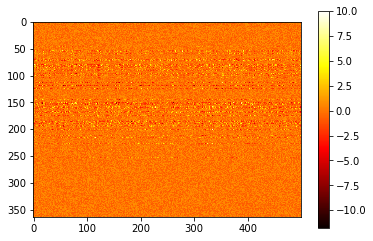

In [6]:
# Re-Double check the weights looks like what we put in
import matplotlib.pyplot as plt

def my_heatmap(x):
    plt.imshow(x, cmap='hot', interpolation='none')
    plt.colorbar()

[my_heatmap(w) for w in model.weights if w.name.startswith("w_hop_oh")]

# Intact triangle model input temporal dynamics
Need to fix Diagnosis class... somehow not really working... check plot input manually

In [7]:
ts = data_wrangling.load_testset('mn_r100')

model.set_active_task('triangle')
y_pred = model([ts['ort']] * cfg.n_timesteps)


2021-11-12 19:16:33.393657: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [46]:
def dense_to_sparse(dense: np.array) -> list:
    """Convert dense representation to sparse representation."""
    sparse = []
    for i, unit in enumerate(dense):
        if unit == 1:
            sparse.append(i)
    return sparse

In [48]:
idx = ts['item'].index('close')
print(dense_to_sparse(ts['ort'][idx]))
print(dense_to_sparse(ts['pho'][idx]))
print(dense_to_sparse(ts['sem'][idx]))

[54, 89, 118, 174, 186]
[29, 31, 52, 60, 62, 87, 90, 92, 94, 96, 102, 107]
[4, 6, 29, 46, 49, 104, 209, 236, 813, 913, 1148]


In [36]:

def get_inputs(y: tf.Tensor, mask: tf.Tensor) -> list:
    """Get the input over time tick.
    Assumed dimensions equal between y and mask:
        y: (timetick, word, unit)
    """
    assert y.shape == mask.shape
    masked_y = mask * y
    mean_y = tf.reduce_sum(masked_y, axis=2) / tf.reduce_sum(mask, axis=2)  # Average over unit (node) dimension
    return tf.reduce_mean(mean_y, axis=1).numpy().tolist()

In [31]:
expanded_sem = tf.cast([ts['sem']] * 13, tf.float32)
masked_sem = expanded_sem * y_pred['sem']
ave_sem_act1 = tf.reduce_sum(masked_sem, axis=2) / tf.reduce_sum(expanded_sem, axis=2)
aot = tf.reduce_mean(ave_sem_act1, axis=1)

In [38]:
pho = tf.cast([ts['pho']] * 13, tf.float32)
sem = tf.cast([ts['sem']] * 13, tf.float32)

In [39]:
# Raw input before TAI
op = get_inputs(y_pred['input_hop_hp'], mask=pho)
os = get_inputs(y_pred['input_hos_hs'], mask=sem)
ps = get_inputs(y_pred['input_hps_hs'], mask=sem)
cs = get_inputs(y_pred['input_css_cs'], mask=sem)

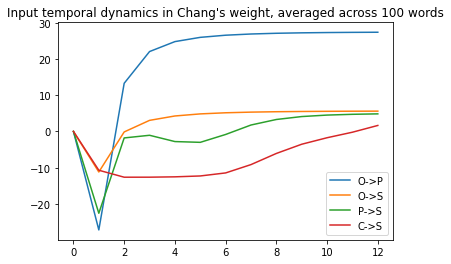

In [42]:
plt.plot(op, label='O->P')
plt.plot(os, label='O->S')
plt.plot(ps, label='P->S')
plt.plot(cs, label='C->S')
plt.legend(loc="lower right")
plt.title("Input temporal dynamics in Chang's weight, averaged across 100 words")
plt.show()

## Collect time invarying elements

In [8]:
layer = 'sem'
target_word = 'close'
target_word_idx = ts['item'].index(target_word)
bias_name = 'bias_s'

df_dict = {}
df_dict["target_act"] = ts[layer][target_word_idx, :]
df_dict["bias"] = [w.numpy() for w in model.weights if w.name.startswith(bias_name)][0]
df_time_invar = pd.DataFrame.from_dict(df_dict)
df_time_invar["unit"] = df_time_invar.index
df_time_invar["word"] = target_word
df_time_invar

,target_act,bias,unit,word
0,0.0,-2.634219,0,close
1,0.0,-2.103109,1,close
2,0.0,-1.273724,2,close
3,0.0,-2.099038,3,close
4,1.0,-1.837062,4,close
...,...,...,...,...
2441,0.0,-4.272089,2441,close
2442,0.0,-3.797071,2442,close
2443,0.0,-4.257431,2443,close
2444,0.0,-4.691223,2444,close


## Collect time varying elements

In [9]:
SEM_NAME_MAP = {
    "input_hps_hs": "PS",
    "input_css_cs": "CS",
    "input_sem_ss": "SS",
    "input_hos_hs": "OS",
    "input_sem": "input",
    "sem": "act",
}
PHO_NAME_MAP = {
    "input_hsp_hp": "SP",
    "input_cpp_cp": "CP",
    "input_pho_pp": "PP",
    "input_hop_hp": "OP",
    "input_pho": "input",
    "pho": "act",
}

name_map = SEM_NAME_MAP

df_time_varying = pd.DataFrame()

for i, model_output_name in enumerate(name_map.keys()):
    this_output_df = pd.DataFrame()
    for t in range(13):
        df_dict = {}
        name = name_map[model_output_name]
        df_dict[name] = y_pred[model_output_name][t, target_word_idx, :]
        this_step_df = pd.DataFrame.from_dict(df_dict)
        this_step_df["timetick"] = t
        this_step_df["unit"] = this_step_df.index
        this_output_df = pd.concat([this_output_df, this_step_df], ignore_index=True)

    if i == 0:
        df_time_varying = this_output_df
    else:
        df_time_varying = pd.merge(
            df_time_varying, this_output_df, on=["timetick", "unit"]
        )

df_time_varying

,PS,timetick,unit,CS,SS,OS,input,act
0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,5.000000e-01
1,0.000000,0,1,0.000000,0.000000,0.000000,0.000000,5.000000e-01
2,0.000000,0,2,0.000000,0.000000,0.000000,0.000000,5.000000e-01
3,0.000000,0,3,0.000000,0.000000,0.000000,0.000000,5.000000e-01
4,0.000000,0,4,0.000000,0.000000,0.000000,0.000000,5.000000e-01
...,...,...,...,...,...,...,...,...
31793,-8.519194,12,2441,-3.174736,0.094540,-1.104074,-18.039394,1.464167e-08
31794,-5.844481,12,2442,-4.165694,0.150971,-4.696007,-19.237715,4.417399e-09
31795,-4.823146,12,2443,-6.466595,0.075323,-1.220229,-16.089689,1.028814e-07
31796,-11.020306,12,2444,-7.732808,0.003940,-1.993777,-24.176319,3.164885e-11


In [18]:
df_time_varying.loc[df_time_varying.act>0.5]

,PS,timetick,unit,CS,SS,OS,input,act
24479,11.745820,10,19,-0.030493,0.009371,2.086039,1.627385,0.835811
25461,5.161246,10,1001,-4.242477,0.003293,10.286044,1.208126,0.769967
26925,12.213028,11,19,1.071834,0.054207,2.138830,5.633402,0.996436
26930,2.940341,11,24,2.084994,-0.029139,4.390696,0.285334,0.570854
27907,5.228791,11,1001,-2.775637,0.011825,10.304584,4.246756,0.985891
29371,12.434217,12,19,2.553104,0.104111,2.173959,8.883276,0.999861
29376,3.157211,12,24,7.239064,-0.025400,4.410080,4.476071,0.988750
30353,5.268645,12,1001,-1.098093,-0.011317,10.316992,6.849111,0.998941


In [10]:
# Merge and export
df = df_time_varying.merge(df_time_invar, on="unit", how="left")
df["unit_acc"] = abs(df.target_act - df.act) < 0.5
df = df[
    ["word", "unit", "unit_acc", "timetick", "target_act", "bias"]
    + list(name_map.values())
]

# Restructure
melt_value_vars = ["bias"] + list(name_map.values())
df = df.melt(
    id_vars=["word", "unit", "timetick", "target_act", "unit_acc"],
    value_vars=melt_value_vars,
)

In [11]:
all_on_nodes = df.loc[df.target_act == 1, "unit"].unique()
all_off_nodes = df.loc[df.target_act == 0, "unit"].unique()
print(f"On: {all_on_nodes} \nOff: {np.random.choice(all_off_nodes, 10)}")

On: [   4    6   29   46   49  104  209  236  813  913 1148] 
Off: [ 554  244  980  124 1242  200  694  426  635  352]


In [12]:
sel_node = all_on_nodes
node_df = df.loc[df.unit.isin(sel_node)]
plot_df = node_df.loc[~node_df.variable.isin(['act', 'input', 'SS', 'PP'])]

alt.Chart(plot_df).mark_line().encode(
    y='mean(value):Q', 
    x='timetick:Q', 
    color='variable:N'
    ).properties(title=f"word: {target_word} at nodes: {sel_node}")

alt.Chart(...)

# Accuracy at the end of training

In [13]:
from scipy.spatial.distance import cosine

In [14]:
def min_cosine_distance_idx(all_reps, pred):
    """return the index of word that has min cosine distance"""
    all_cosine_dist = [cosine(pred, rep) for rep in all_reps]
    return np.argmin(all_cosine_dist) 

def cosine_accuracy(all_reps, pred, target):
    """Check whether the prediction is the min cosine distance word"""
    target_idx = min_cosine_distance_idx(all_reps, target)
    pred_idx = min_cosine_distance_idx(all_reps, pred)
    return target_idx == pred_idx

def all_cosine_accuracy(all_reps, preds, targets):
    return np.mean([cosine_accuracy(all_reps, pred, target) for pred, target in zip(preds, targets)])

def binary_accuracy(pred, target):
    """Calculate correct side accuracy"""
    d = abs(pred - target)
    max_d = np.max(d, axis = 1)
    # print(max_d)
    return np.mean(max_d < 0.5)

def get_all_acc(y_pred):
    """Calculate accuracy of all outputs"""
    mn_train = data_wrangling.load_testset('mn_train')
    sem_acc = all_cosine_accuracy(all_reps=mn_train['sem'], preds=y_pred['sem'][-1].numpy(), targets=ts['sem'])
    pho_acc = binary_accuracy(ts['pho'], y_pred['pho'][-1, :, :].numpy())
    return {
        "pho": pho_acc,
        "sem": sem_acc
    }

def get_task_acc(task):
    """Get task acc"""
    model.set_active_task(task)
    input_name = modeling.IN_OUT[task][0]
    y_pred = model([ts[input_name]] * cfg.n_timesteps)
    return get_all_acc(y_pred)


In [15]:
get_task_acc('triangle')

{'pho': 0.96, 'sem': 0.88}

In [21]:
get_task_acc('ort_sem')

{'pho': 0.0, 'sem': 0.24}

In [22]:
get_task_acc('exp_ops')

{'pho': 0.96, 'sem': 0.31}

In [23]:
get_task_acc('exp_osp')

{'pho': 0.0, 'sem': 0.07}

In [24]:
get_task_acc('ort_pho')

/opt/conda/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


{'pho': 0.96, 'sem': 0.0}